In [1]:
import os
import json
#!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
cid ='d8762235995b4ddcbc0df90739df9a63' # Client ID; copy this from your app created on beta.developer.spotify.com
secret = '887a4eccdbde4195bfc0f7f4c472fe70' # Client Secret; copy this from your app
username = '12155311349' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'
redirect_uri='https://localhost:8080/callback/'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret,redirect_uri="https://localhost:8080/callback/")
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
# song_name = input("Search a song for recommendations: ")

# User Playlist


In [4]:
#Creating function and having user give PlaylistID, and genre (0 = counrty, 1 = rock...)
def input_playlist(playlistID, genre): 

    playlist = sp.user_playlist(username, playlistID);

    tracks = playlist["tracks"];
    songs = tracks["items"];
    total_tracks = tracks["total"]
    
    # Iterate over all tracks in the playlist using offset to get beyond the first 100 tracks
    for i in range(100, total_tracks, 100):
        tracks = sp.user_playlist_tracks(username, playlistID, offset=i)
        songs += tracks["items"]
        
    #Putting Track ID, Track Name, Album, and artist name in matrix's

    track_ids = [] 
    track_names = []
    album = []
    artist =[]

    #Getting Track Data
    for i in range(0, len(songs)):
        if songs[i]['track']['id'] != None: # Removes the local tracks in your playlist if there is any
            track_ids.append(songs[i]['track']['id'])
            track_names.append(songs[i]['track']['name'])
            album.append(songs[i]['track']['album']['name'])
            artist.append(songs[i]['track']['artists'][0]['name'])

    features = []
    for i in range(0,len(songs)):
        audio_features = sp.audio_features(track_ids[i])
        for track in audio_features:

          if track is None:
            print(track)
            features.append({'danceability': 0, 'energy': 0, 'key': 0, 'loudness': 0, 'mode': 0, 'speechiness': 0, 'acousticness': 0, 'instrumentalness': 0, 'liveness': 0, 'valence': 0, 'tempo': 0, 'type': 'audio_features', 'id': '00000', 'uri': 'spotify:track:0', 'track_href': 'https://api.spotify.com/', 'analysis_url': 'https://api.spotify.com/', 'duration_ms': 0, 'time_signature': 0})
          else:
            features.append(track)

    #Creating our DataFrames
    df = pd.DataFrame(features, index = track_names) 

    #Adding a new column
    df['genre'] = genre #Country
    df['Song Title'] = track_names
    df['Artist'] = artist

    # Scale between 0 and 1
    df["key"] = (df["key"] / df["key"].max())
    df["tempo"] = (df["tempo"] / df["tempo"].max())
    df["loudness"] = (df["loudness"] / df["loudness"].min())
    
    #calculate the IQR for instrumentalness and acousticness
    Q1 = df["instrumentalness"].quantile(0.25)
    Q3 = df["instrumentalness"].quantile(0.75)
    IQR = Q3 - Q1
    
    Q12 = df["acousticness"].quantile(0.25)
    Q32 = df["acousticness"].quantile(0.75)
    IQR2 = Q32 - Q12
    
    #Remove rows with outliers
    df = df[~((df["instrumentalness"] < (df["instrumentalness"].quantile(0.25) - 1.5 * IQR)) | (df["instrumentalness"] > (df["instrumentalness"].quantile(0.75) + 1.5 * IQR)))]
    df = df[~((df["acousticness"] < (df["acousticness"].quantile(0.25) - 1.5 * IQR2)) | (df["acousticness"] > (df["acousticness"].quantile(0.75) + 1.5 * IQR2)))]
    
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[~((df.sub(Q1, axis=1).div(IQR, axis=1)).lt(-1.5) | (df.sub(Q1, axis=1).div(IQR, axis=1)).gt(1.5)).any(axis=1)]
    return df

In [5]:
# userPlaylistID= 'https://open.spotify.com/playlist/4sqXF15KIWE1C5uPwB6z42?si=9a8303cdec2d4512' #Retro Playlist


## Getting User's Playlist 

In [6]:
# get the user's playlists
playlists = sp.current_user_playlists()

# create a DataFrame with the playlist names and IDs
playlist_df = pd.DataFrame([(playlist['name'], playlist['id']) for playlist in playlists['items']],
                           columns=['name', 'id'])

# print the DataFrame
print('Your Playlists, Please Choose one: ')
print(playlist_df)

Your Playlists, Please Choose one: 
                       name                      id
0          Boops & Bops (2)  0ohuHjbjIUaTWcpXro9OcI
1                Yacht Rock  5PlFP6HbcJKMqAZ557UgSG
2          Retro-Futuristic  4P3NZ1qRZn9eDLpy59YOdj
3       Your Top Songs 2022  37i9dQZF1F0sijgNaJdgit
4                   Ctrl-Z   0LqP73YrMlMPj75eZmHbHQ
5               Late Nights  2Wh1QbUaF8u4YbhgfrggN8
6                     Gunna  4sqXF15KIWE1C5uPwB6z42
7               Soundtracks  7b5PVaqf7XgxhfREmtA8yk
8                  Idk Pt.2  4oqk4msJ6FeXuUNNi86TrF
9     A love letter to my b  1xxDBSV0DtzAVtQB4naFHx
10               Happy Boy   0jb7Z7LM2TAFjzp9jEqbDg
11  Mac,Peep, Juice, and X😭  6vh2KPguZEElntUuSENfjV
12                 Yeehaw🤠   4d8nG1173ayUdz2n5XFNT0
13                 Pop Bops  19FYjhrL2YynmNparMFCYT
14           Decade Greats   3VIhTq6a5UvGtwULvyEjcB
15            Rainy Days🌧☔️  1k8NJQPygIDVi5tqTBXiw9
16         Sophomore Year✌️  2LkOh05YTCnqkPYnpwJyK1
17                Intense😤😤 

## Asking for the playlist

In [7]:
# ask the user to enter a playlist name
playlist_name = input("Enter a playlist name (partial or full): ")

# find the playlist ID that matches the user's input
matching_playlists = playlist_df[playlist_df['name'].str.contains(playlist_name, case=False)]
if len(matching_playlists) == 0:
    print("No matching playlists found.")
else:
    playlist_id = matching_playlists.iloc[0]['id']
    print(f"Selected playlist: {matching_playlists.iloc[0]['name']} (ID: {playlist_id})")

Enter a playlist name (partial or full): Yach
Selected playlist: Yacht Rock (ID: 5PlFP6HbcJKMqAZ557UgSG)


In [8]:
playlist = sp.user_playlist(username, playlist_id);

In [9]:
columns = ['song name', 'artist', 'popularity', 'release date', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track in enumerate(playlist['tracks']['items']):
    name = track['track']['name']
    artist = track['track']['artists'][0]['name']
    popularity = track['track']['popularity']
    year = track['track']['album']['release_date'][:4]
    track_id = track['track']['id']
    audio_features = sp.audio_features([track_id])[0]
    if audio_features is None:
        danceability = 0
        loudness = 0
        energy = 0
        speechiness = 0
        acousticness = 0
        instrumentalness = 0
        liveness = 0
        valence = 0
        tempo = 0
    else:
        danceability = audio_features['danceability']
        loudness = audio_features['loudness']
        energy = audio_features['energy']
        speechiness = audio_features['speechiness']
        acousticness = audio_features['acousticness']
        instrumentalness = audio_features['instrumentalness']
        liveness = audio_features['liveness']
        valence = audio_features['valence']
        tempo = audio_features['tempo']
    data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df = pd.DataFrame(data, columns=columns)

In [10]:
df

,song name,artist,popularity,release date,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Goodbye Stranger - 2010 Remastered,Supertramp,69,1979,67oyFnjJnn78fZP9KjeZx0,0.420,-7.350,0.668,0.0517,0.607000,0.016000,0.0585,0.3380,125.391
1,Reminiscing - Remastered 2022,Little River Band,69,1978,7i3xpu7SFWvzhGa9AZyySR,0.350,-11.010,0.443,0.0369,0.762000,0.001920,0.0994,0.3450,189.125
2,Lowdown,Boz Scaggs,65,1976,0nlZjTPzW6S9JIESuGfImT,0.662,-5.544,0.788,0.0635,0.081200,0.141000,0.0351,0.9290,116.499
3,What a Fool Believes,The Doobie Brothers,72,1978,2yBVeksU2EtrPJbTu4ZslK,0.758,-15.308,0.378,0.0449,0.284000,0.000000,0.0490,0.9850,120.736
4,One of These Nights - 2013 Remaster,Eagles,73,1975,608xszaAxVh4m7NcKJiAbF,0.655,-10.385,0.606,0.0285,0.060300,0.078900,0.0757,0.7650,110.061
5,New Kid in Town - 2013 Remaster,Eagles,68,1976,6Zyz8lsnMFpIrCTuvGurCB,0.649,-9.811,0.425,0.0267,0.378000,0.001300,0.1080,0.6510,107.383
6,Heart Of Glass (Live from the iHeart Festival),Miley Cyrus,73,2020,5GK1GYXH16RdfmltogHhAk,0.580,-5.303,0.908,0.0341,0.000335,0.000048,0.0870,0.4270,115.016
7,Summer Breeze,Seals and Crofts,66,1972,3B0ms7Xlxl16tRztKHpcu9,0.490,-6.566,0.581,0.0388,0.553000,0.017700,0.0764,0.3180,88.718
8,The Girl Is Mine (with Paul McCartney),Michael Jackson,34,2005,15fvDRnqFdogjUM8PUC0ml,0.684,-6.337,0.676,0.0535,0.308000,0.000000,0.1770,0.6930,81.408
9,Life in the Fast Lane - 2013 Remaster,Eagles,73,1976,6gXrEUzibufX9xYPk3HD5p,0.667,-7.246,0.755,0.0690,0.096600,0.000069,0.0523,0.8830,109.535


# Getting Recommendations 

In [11]:
recom = []

for index, row in df.iterrows():
    # Find similar songs based on audio features, year, and popularity
    similar_songs = sp.recommendations(seed_tracks=[row['iD']], target_popularity=popularity, limit=5, **audio_features)
    recom.append(similar_songs)
        
# Extract relevant info from recommendations and store in DataFrame
columns = ['name', 'artist', 'popularity', 'year', 'iD', 'danceability', 'energy','loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data = []
for i, track_list in enumerate(recom):
    for track in track_list['tracks']:
        name = track['name']
        artist = track['artists'][0]['name']
        popularity = track['popularity']
        year = track['album']['release_date'][:4]
        track_id = track['id']
        audio_features = sp.audio_features([track_id])[0]
        if audio_features is None:
            danceability = 0
            loudness = 0
            energy = 0
            speechiness = 0
            acousticness = 0
            instrumentalness = 0
            liveness = 0
            valence = 0
            tempo = 0
        else:
            danceability = audio_features['danceability']
            loudness = audio_features['loudness']
            energy = audio_features['energy']
            speechiness = audio_features['speechiness']
            acousticness = audio_features['acousticness']
            instrumentalness = audio_features['instrumentalness']
            liveness = audio_features['liveness']
            valence = audio_features['valence']
            tempo = audio_features['tempo']
        data.append([name, artist, popularity, year, track_id, danceability, loudness,energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo])
df_recom = pd.DataFrame(data, columns=columns)

# Scale between 0 and 1
df_recom["tempo"] = (df_recom["tempo"] / df_recom["tempo"].max())
df_recom["loudness"] = (df_recom["loudness"] / df_recom["loudness"].max())
df_recom["energy"] = (df_recom["energy"] / df_recom["energy"].min())
df_recom["popularity"] = (df_recom["popularity"] / 100)

df_recom


,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Tin Man,America,0.62,1974,4uTTd2SlalZoG0zVgI63kH,0.646,0.493344,0.547423,0.0671,0.5280,0.013300,0.0836,0.655,0.905230
1,Scenes from an Italian Restaurant,Billy Joel,0.62,1977,3utq2FgD1pkmIoaWfjXWAU,0.415,0.228169,0.959794,0.1260,0.4070,0.000501,0.1140,0.339,0.515463
2,Give Me Love (Give Me Peace on Earth),George Harrison,0.62,1973,71fXxvXqo1zxWDtBmjoEVk,0.385,0.534010,0.587629,0.0464,0.4920,0.013000,0.1300,0.637,0.426098
3,Can't Stand Losing You,The Police,0.62,1992,4scS449npSaFolwj9b4RJD,0.782,0.551942,0.565979,0.3440,0.0647,0.000111,0.0774,0.955,0.749801
4,Stay - Remastered,Jackson Browne,0.62,1977,5eMjcHVRRh1tbimTgJPoGn,0.603,0.378071,0.788660,0.0275,0.0974,0.296000,0.1100,0.720,0.563430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,So Into You,Atlanta Rhythm Section,0.62,1976,3Sm5TYFgMXyXwgAcY2xweX,0.622,0.616806,0.421649,0.0362,0.6500,0.023000,0.1420,0.785,0.453473
191,Deacon Blues,Steely Dan,0.62,1977,61AK5ICbKk20h1dFS3mXuu,0.745,0.571200,0.604124,0.0359,0.4570,0.000295,0.1190,0.604,0.609681
192,Tin Man,America,0.62,1974,4uTTd2SlalZoG0zVgI63kH,0.646,0.493344,0.547423,0.0671,0.5280,0.013300,0.0836,0.655,0.905230
193,Give Me Love (Give Me Peace on Earth),George Harrison,0.62,1973,71fXxvXqo1zxWDtBmjoEVk,0.385,0.534010,0.587629,0.0464,0.4920,0.013000,0.1300,0.637,0.426098


In [12]:
df_recom = df_recom.drop_duplicates(subset=['name'])

C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\zarek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zarek\AppData\Local\Temp\ipykernel_17116\4066906094.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recom['clusters'] = labels
No artists with labels found to put in legend.  Note that artists whose label start with

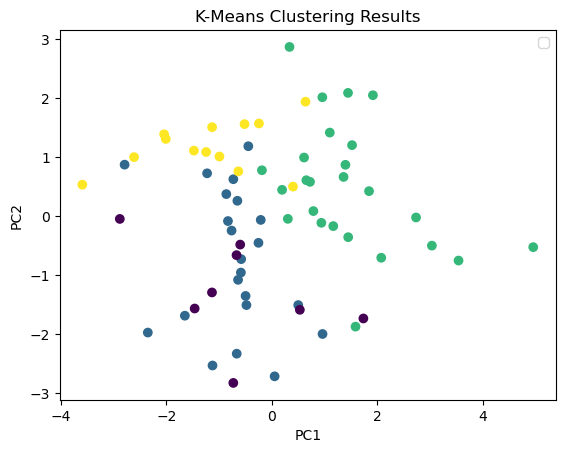

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

# Define the features to use for the model
features = ['year','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Create a new dataframe with only the features to use for the model
df_model = df_recom[features]

# Scale the features
scaler = StandardScaler()
df_model_scaled = scaler.fit_transform(df_model)

# Fit the K-means model using the new dataframeabs
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_model_scaled)

# Export the K-means model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Get the cluster labels for each data point
labels = kmeans.labels_
df_recom['clusters'] = labels
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_model_scaled)

# Plot the data points with different colors based on their cluster labels
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()

In [14]:
df_recom

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,Tin Man,America,0.62,1974,4uTTd2SlalZoG0zVgI63kH,0.646,0.493344,0.547423,0.0671,0.5280,0.013300,0.0836,0.655,0.905230,2
1,Scenes from an Italian Restaurant,Billy Joel,0.62,1977,3utq2FgD1pkmIoaWfjXWAU,0.415,0.228169,0.959794,0.1260,0.4070,0.000501,0.1140,0.339,0.515463,1
2,Give Me Love (Give Me Peace on Earth),George Harrison,0.62,1973,71fXxvXqo1zxWDtBmjoEVk,0.385,0.534010,0.587629,0.0464,0.4920,0.013000,0.1300,0.637,0.426098,2
3,Can't Stand Losing You,The Police,0.62,1992,4scS449npSaFolwj9b4RJD,0.782,0.551942,0.565979,0.3440,0.0647,0.000111,0.0774,0.955,0.749801,1
4,Stay - Remastered,Jackson Browne,0.62,1977,5eMjcHVRRh1tbimTgJPoGn,0.603,0.378071,0.788660,0.0275,0.0974,0.296000,0.1100,0.720,0.563430,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,The Rain Song - Remaster,Led Zeppelin,0.62,1973,3JLrri1xSCui3bzITDJbkk,0.336,0.522026,0.327835,0.0263,0.3170,0.071600,0.1110,0.240,0.419199,2
163,The Night They Drove Old Dixie Down,The Band,0.62,1969,2nvcTDmZkRWKNMAL29sLHo,0.505,0.424134,0.497938,0.0334,0.5420,0.000000,0.2220,0.484,0.662209,2
172,On the Road Again,Willie Nelson,0.62,1988,2GyH5rvdnfkjzsTFaWrrov,0.714,0.518823,0.678351,0.0375,0.6540,0.091400,0.7780,0.850,0.583964,3
174,Whiskey In The Jar,Thin Lizzy,0.62,1972,2uLx3Gka9TGCz9Zgu7Uwav,0.557,0.505192,0.714433,0.0445,0.5310,0.001410,0.1960,0.747,0.671113,2


In [15]:
# filter the data to only include cluster 2 values
cluster_0_data = df_recom[df_recom['clusters']==0]
cluster_1_data = df_recom[df_recom['clusters']==1]
cluster_2_data = df_recom[df_recom['clusters'] == 2]
cluster_3_data = df_recom[df_recom['clusters']==3]

In [16]:
cluster_0_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
30,FU (feat. French Montana),Miley Cyrus,0.62,2013,6dDIOU6AqgLkrjFNPgvKY6,0.548,0.150679,0.858763,0.0497,0.1990,0.000000,0.3050,0.467,1.000000,0
31,Defenceless,Louis Tomlinson,0.62,2020,74YzCrLzu7fw0AasX3CEwv,0.638,0.268652,0.668041,0.0471,0.0973,0.000000,0.1220,0.508,0.626183,0
33,Supalonely (feat. Gus Dapperton),BENEE,0.62,2020,3GZoWLVbmxcBys6g0DLFLf,0.862,0.217099,0.650515,0.0515,0.2910,0.000209,0.1230,0.841,0.678728,0
34,Baby,Madison Beer,0.62,2021,1X4ZkhlRRohkV33cITaJYs,0.705,0.236677,0.728866,0.0534,0.0799,0.000000,0.1490,0.452,0.620821,0
121,All The Time,Bahamas,0.62,2014,0qI1W6chJgvrSAzAkX9JBa,0.711,0.220301,0.478351,0.0488,0.6480,0.003730,0.0846,0.507,0.669761,0


In [17]:
cluster_1_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
1,Scenes from an Italian Restaurant,Billy Joel,0.62,1977,3utq2FgD1pkmIoaWfjXWAU,0.415,0.228169,0.959794,0.1260,0.4070,0.000501,0.1140,0.339,0.515463,1
3,Can't Stand Losing You,The Police,0.62,1992,4scS449npSaFolwj9b4RJD,0.782,0.551942,0.565979,0.3440,0.0647,0.000111,0.0774,0.955,0.749801,1
4,Stay - Remastered,Jackson Browne,0.62,1977,5eMjcHVRRh1tbimTgJPoGn,0.603,0.378071,0.788660,0.0275,0.0974,0.296000,0.1100,0.720,0.563430,1
19,Somebody's Baby,Jackson Browne,0.62,1997,4SlCb8n5Jw52astU7GWPyV,0.741,0.357806,0.764948,0.0269,0.1460,0.000016,0.1060,0.889,0.615438,1
28,All Right,Christopher Cross,0.62,1983,5tE2kEW1Jom3Qc93UPBT79,0.711,0.239010,0.667010,0.0353,0.1700,0.000000,0.2340,0.504,0.698588,1


In [18]:
cluster_2_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
0,Tin Man,America,0.62,1974,4uTTd2SlalZoG0zVgI63kH,0.646,0.493344,0.547423,0.0671,0.528,0.013300,0.0836,0.655,0.905230,2
2,Give Me Love (Give Me Peace on Earth),George Harrison,0.62,1973,71fXxvXqo1zxWDtBmjoEVk,0.385,0.534010,0.587629,0.0464,0.492,0.013000,0.1300,0.637,0.426098,2
5,Cool Change - Remastered 2022,Little River Band,0.62,1979,2SEGYVnWImKLUOkU3Qa8sX,0.375,0.500480,0.394845,0.0277,0.268,0.000001,0.0877,0.143,0.685474,2
6,How Much I Feel,Ambrosia,0.62,1978,3GVhCuS4BRxCTvVj4Cmc8w,0.667,0.364119,0.528866,0.0260,0.305,0.000000,0.0851,0.518,0.501534,2
7,So Into You,Atlanta Rhythm Section,0.62,1976,3Sm5TYFgMXyXwgAcY2xweX,0.622,0.616806,0.421649,0.0362,0.650,0.023000,0.1420,0.785,0.453473,2


In [19]:
cluster_3_data.head()

,name,artist,popularity,year,iD,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
18,Lonesome Loser - Remastered 2022,Little River Band,0.62,1979,0EOTFIX60ua9qt8pel84tA,0.453,0.355427,0.608247,0.0248,0.06130,0.000000,0.290,0.434,0.578433,3
21,Mainstreet,Bob Seger,0.62,1976,0XVR94voJPToKX1XoOw0ot,0.505,0.248022,0.770103,0.0308,0.06400,0.006470,0.244,0.529,0.736019,3
23,Magic Man,Heart,0.62,1975,4sUlsy0tPv9n5nqrqeA0lE,0.435,0.586249,0.457732,0.0336,0.15900,0.000705,0.457,0.734,0.546327,3
25,Already Gone - 2013 Remaster,Eagles,0.62,1974,0CKxrnF9KplS21LTjkkqsW,0.465,0.292667,0.837113,0.0467,0.00591,0.000494,0.408,0.811,0.769356,3
42,Tell Her About It,Billy Joel,0.62,1983,6kCJMxv445L2okuTiou1fR,0.565,0.239742,0.921649,0.1750,0.00777,0.000000,0.490,0.737,0.959127,3


In [24]:
user_id = username

# Define a dictionary to hold the cluster playlists
cluster_playlists = {}

# Loop through the clusters and create a new playlist for each one
for cluster_id in range(4):
    playlist_name = f'Cluster {cluster_id}'
    playlist = sp.user_playlist_create(user=user_id, name=playlist_name)
    cluster_playlists[cluster_id] = playlist['id']

# Loop through the songs in each cluster and add them to their corresponding playlist
for cluster_id, cluster_data in enumerate([cluster_0_data, cluster_1_data, cluster_2_data, cluster_3_data]):
    for _, song_data in cluster_data.iterrows():
        song_id = song_data['iD']
        track_info = sp.track(song_id)
        track_uri = track_info['uri']
        sp.user_playlist_add_tracks(user=user_id, playlist_id=cluster_playlists[cluster_id], tracks=[track_uri])


In [26]:
# Define a list to hold the playlist information
playlist_info = []

# Loop through the cluster playlists and add the playlist ID and name to the list
for cluster_id in range(4):
    playlist_id = cluster_playlists[cluster_id]
    playlist_name = f'Cluster {cluster_id} Playlist'
    playlist_info.append({'Name': playlist_name, 'id': playlist_id})

# Create a DataFrame from the playlist information
playlist_df = pd.DataFrame(playlist_info)

# Display the playlist IDs and names
print(playlist_df)

                 Name                      id
0  Cluster 0 Playlist  3Gdawu9Ihw0jp8J7Hw6dXv
1  Cluster 1 Playlist  0VolZhvheVBz3oG2nbkZWT
2  Cluster 2 Playlist  2N77Y5qjZd00WpJA7buFFu
3  Cluster 3 Playlist  5CCupUyqN5t0txNtx1OcBF


In [ ]:
while True:
        action = input("Do you want to keep all playlists, delete all playlists, or keep a specific playlist? (Enter 'all', 'none', or a cluster number): ")
        if action == 'all':
            print("All playlists will be kept.")
        elif action == 'none':
            for playlist_id in playlist_df['id']:
                sp.user_playlist_unfollow(user=user_id, playlist_id=playlist_id)
            print("All playlists have been deleted.")
        elif action.isdigit() and 0 <= int(action) < 4:
            cluster_id = int(action)
            playlist_id = cluster_playlists[cluster_id]
            print(f"Playlist '{playlist_df.iloc[cluster_id]['Name']}' will be kept.")
            playlist_df = playlist_df.iloc[[cluster_id]]
        else:
            print("Invalid input. Please enter 'all', 'none', or a cluster number (0-3).")

Do you want to keep all playlists, delete all playlists, or keep a specific playlist? (Enter 'all', 'none', or a cluster number): none
All playlists have been deleted.
